In [3]:
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

### Here I am thinking about using the Thornthwaite equation to estimate PET over the riparian zone for a week longer period to see the difference that makes as a conservative water allocation estimate for riparian zone ET
- if water is moving through this system more slowly, what difference does it make to PET? How much more PET would we have if water takes longer to move through a basin
- Thornthwaite was used as an analysis found it be have the best v

In [4]:
ucrb_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_rivers = gpd.read_file('../basin_characteristics/Colorado_River_Basin_Rivers.geojson')
# convert crs to 32613
ucrb_rivers = ucrb_rivers.to_crs(32613)

In [5]:
terraclimate_pet = xr.open_dataset('../data/etdata/TerraClimate19812010_pet.nc')/30
# add a datapoint for the time dimension equal to the first time step but with a data of 1962-01-01
dummy_pet = terraclimate_pet.sel(time='1961-01-01')
# change the date to 1962-01-01
dummy_pet = dummy_pet.assign_coords(time=pd.to_datetime(dt.date(1962,1,1)))
# add the dummy point to the dataset
terraclimate_pet = xr.concat([terraclimate_pet, dummy_pet], dim='time')
# resample to daily data
terraclimate_pet_daily = terraclimate_pet.resample(time='1D').interpolate('cubic')
# convert to a raster and change crs to match the UCRB boundary
terraclimate_pet_daily = terraclimate_pet_daily.rio.write_crs(4326).rio.clip(ucrb_boundary.geometry)
# convert crs to 32613
terraclimate_pet_daily = terraclimate_pet_daily.rio.reproject(dst_crs = 32613).rio.clip(ucrb_rivers.buffer(1000).geometry)
terraclimate_pet_daily = terraclimate_pet_daily.where(terraclimate_pet_daily.pet<1000)


/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'pet' has multiple fill values {-32768, 32768}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [6]:
# import the riparian vegetation 
riparian_zone = rxr.open_rasterio('../basin_characteristics/riparian_zone_1000m.tif')
# match resolution of terraclimate_pet_daily
riparian_zone_match = riparian_zone.rio.reproject_match(terraclimate_pet_daily)
# create a mask of the riparian zone with values less than or equal to 25
riparian_mask = (riparian_zone_match <= 25) & (riparian_zone_match >= 0)

In [7]:
(terraclimate_pet).sum(dim=['time']).mean(dim=['lat','lon']).pet



<xarray.DataArray 'pet' ()>
array(34.35194, dtype=float32)

In [8]:
# reprojecting the riparian mask to the same projection as the pet data
riparian_extension_14day_mm_late = terraclimate_pet_daily.where(riparian_mask.squeeze()).rolling(time=15).sum(dim='time')
riparian_extension_14day_mm_early = terraclimate_pet_daily.where(riparian_mask.squeeze()).sel(time=slice('1961-04-01','1961-04-15')).pet.sum(dim=['x','y']).sum(dim='time')
riparian_extension_14day_late_m3 = (riparian_extension_14day_mm_late / 1000) * 4223.64253638965 * 4223.64253638965
riparian_extension_14day_early_m3 = (riparian_extension_14day_mm_early / 1000) * 4223.64253638965 * 4223.64253638965
riparian_extension_14day = ((terraclimate_pet_daily.where(riparian_mask.squeeze()).rolling(time=14).sum().sum(dim=['x', 'y'])/1000) * 4223.64253638965 * 4223.64253638965)
riparian_extension_5day = ((terraclimate_pet_daily.where(riparian_mask.squeeze()).rolling(time=5).sum().sum(dim=['x', 'y'])/1000) * 4223.64253638965 * 4223.64253638965)

In [9]:
filepath = '../data/etdata/UCRB_large_res_evaporation/'
filelist = os.listdir(filepath)
evaporation_files = [file for file in filelist if 'evaporation' in file]
res_et_list = []
for i,file in enumerate(evaporation_files):
    res_name = evaporation_files[i].split('_evaporation.csv')[0]
    res_et = pd.read_csv(os.path.join(filepath,file), index_col=0)
    res_et.index = pd.to_datetime(res_et.index)
    res_et['WY'] = res_et.index.year.where(res_et.index.month<10, res_et.index.year+1)
    # Convert to cubic meters of water 
    acreft_2_cubicmeter = 1233.48
    res_et['evaporation'] = res_et['evaporation']*acreft_2_cubicmeter
    res_et = res_et.rename(columns={'evaporation':res_name})
    out_res = res_et.groupby('WY').sum()
    res_et_list.append(out_res.tail(-1).head(-1))

filepath = '../data/etdata/UCRB_large_res_evaporation/'
filelist = os.listdir(filepath)
area_files = [file for file in filelist if 'area' in file]
res_area_list = []
for i,file in enumerate(area_files):
    res_name = area_files[i].split('_area.csv')[0]
    res_area = pd.read_csv(os.path.join(filepath,file), index_col=0)
    res_area.index = pd.to_datetime(res_area.index)
    res_area['WY'] = res_area.index.year.where(res_area.index.month<10, res_area.index.year+1)
    # Convert to cubic meters of water 
    acre_2_sqm = 4046.86
    res_area['area'] = res_area['area']*4046.86
    res_area = res_area.rename(columns={'area':res_name})
    out_res = res_area.groupby('WY').mean()
    res_area_list.append(out_res.tail(-1).head(-1))
    
res_et_df = pd.concat(res_et_list, axis=1).sort_index()
res_area_df = pd.concat(res_area_list, axis=1).sort_index()

In [60]:
filepath = '../data/etdata/UCRB_large_res_evaporation/'
filelist = os.listdir(filepath)
storage_files = [file for file in filelist if 'storage_acre_ft' in file]
res_volume_list = []
for i,file in enumerate(storage_files):
    res_name = storage_files[i].split('storage_acre_ft.csv')[0]
    res_storage = pd.read_csv(os.path.join(filepath,file), index_col=0)
    res_storage.index = pd.to_datetime(res_storage.index)
    res_storage['WY'] = res_storage.index.year.where(res_storage.index.month<10, res_storage.index.year+1)
    # Convert to cubic meters of water 
    acreft_2_cubicmeter = 1233.48
    res_storage['storage'] = res_storage['storage'] #*acreft_2_cubicmeter
    res_storage = res_storage.rename(columns={'storage':res_name})
    out_res = res_storage.groupby('WY').mean()
    res_volume_list.append(out_res.tail(-1).head(-1))
    
lake_mead_volume_df = pd.concat(res_volume_list, axis=1)

In [61]:
lake_mead_volume_df.iloc[0]

lake_mead_   14724280.09
Name: 1938, dtype: float64

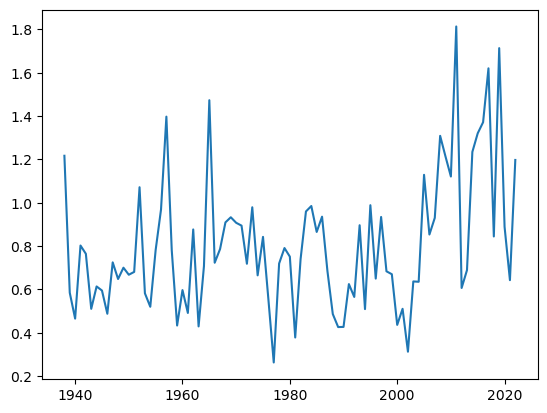

In [64]:
# import naturalized flow
ucrb_naturalized_streamflow = pd.read_csv('../data/streamflowdata/LF_NATURALIZED_FLOW.csv', header=None, index_col=0)
# ucrb_naturalized_streamflow = ucrb_naturalized_streamflow.rename(columns={1:'annual_flow_km3'}) * 1.23348e-6
# convert from km3 to m3
# ((ucrb_naturalized_streamflow * 1e9).rolling(20).mean().iloc[-1]).values
df = pd.concat([ucrb_naturalized_streamflow,lake_mead_volume_df], axis=1)
# divide the columns by each other
df['ratio'] = df[1] /( df['lake_mead_'])

(df['ratio']).plot()
# remove scientific notation from plot
plt.ticklabel_format(style='plain', axis='y')

In [76]:
ucrb_naturalized_streamflow.iloc[-22:].mean()/ucrb_naturalized_streamflow.loc[:1999].mean()

1   0.80
dtype: float64

In [15]:
riparian_extension_14day = riparian_extension_14day.pet.to_dataframe()['pet'].reset_index()
riparian_extension_5day = riparian_extension_5day.pet.to_dataframe()['pet'].reset_index()


Text(0.5, 1.0, 'Order of Magnitude Estimate of IQR Extension Impact on Riparian ET')

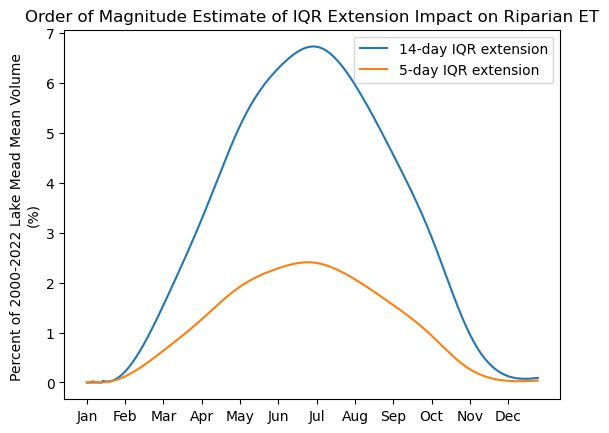

In [68]:
(100*(riparian_extension_14day.pet/((lake_mead_volume_df * acreft_2_cubicmeter).rolling(22).mean().iloc[-1]).values)).plot(label='14-day IQR extension')
(100*(riparian_extension_5day.pet/((lake_mead_volume_df * acreft_2_cubicmeter).rolling(22).mean().iloc[-1]).values)).plot(label='5-day IQR extension')
# add a horizontal line at 100%
# plt.axhline(100, color='k', linestyle='--', lw=2)
# change y axis to percent of lake powell average et
plt.ylabel('Percent of 2000-2022 Lake Mead Mean Volume \n(%)')
# change the xticks to be months of the year
plt.xticks(np.arange(0, 365, 31), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
                                      'Nov', 'Dec']);
# set xlim to 90 to 200
# plt.xlim(90, 200)        
plt.legend();                                  
plt.title('Order of Magnitude Estimate of IQR Extension Impact on Riparian ET')